#Introduction

Definition:
> *Time Series* is a series of data points indexed in time order


Import Libreries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization


import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Upload CSV Files


In [6]:
from google.colab import files
uploaded = files.upload()

Saving ads.csv to ads.csv
Saving currency.csv to currency.csv


In [10]:
ads = pd.read_csv('/content/ads.csv',index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('/content/currency.csv',index_col=['Time'],parse_dates=['Time'])

ads.head()
currency.head()

,GEMS_GEMS_SPENT
Time,
2017-05-01,1199436
2017-05-02,1045515
2017-05-03,586111
2017-05-04,856601
2017-05-05,793775


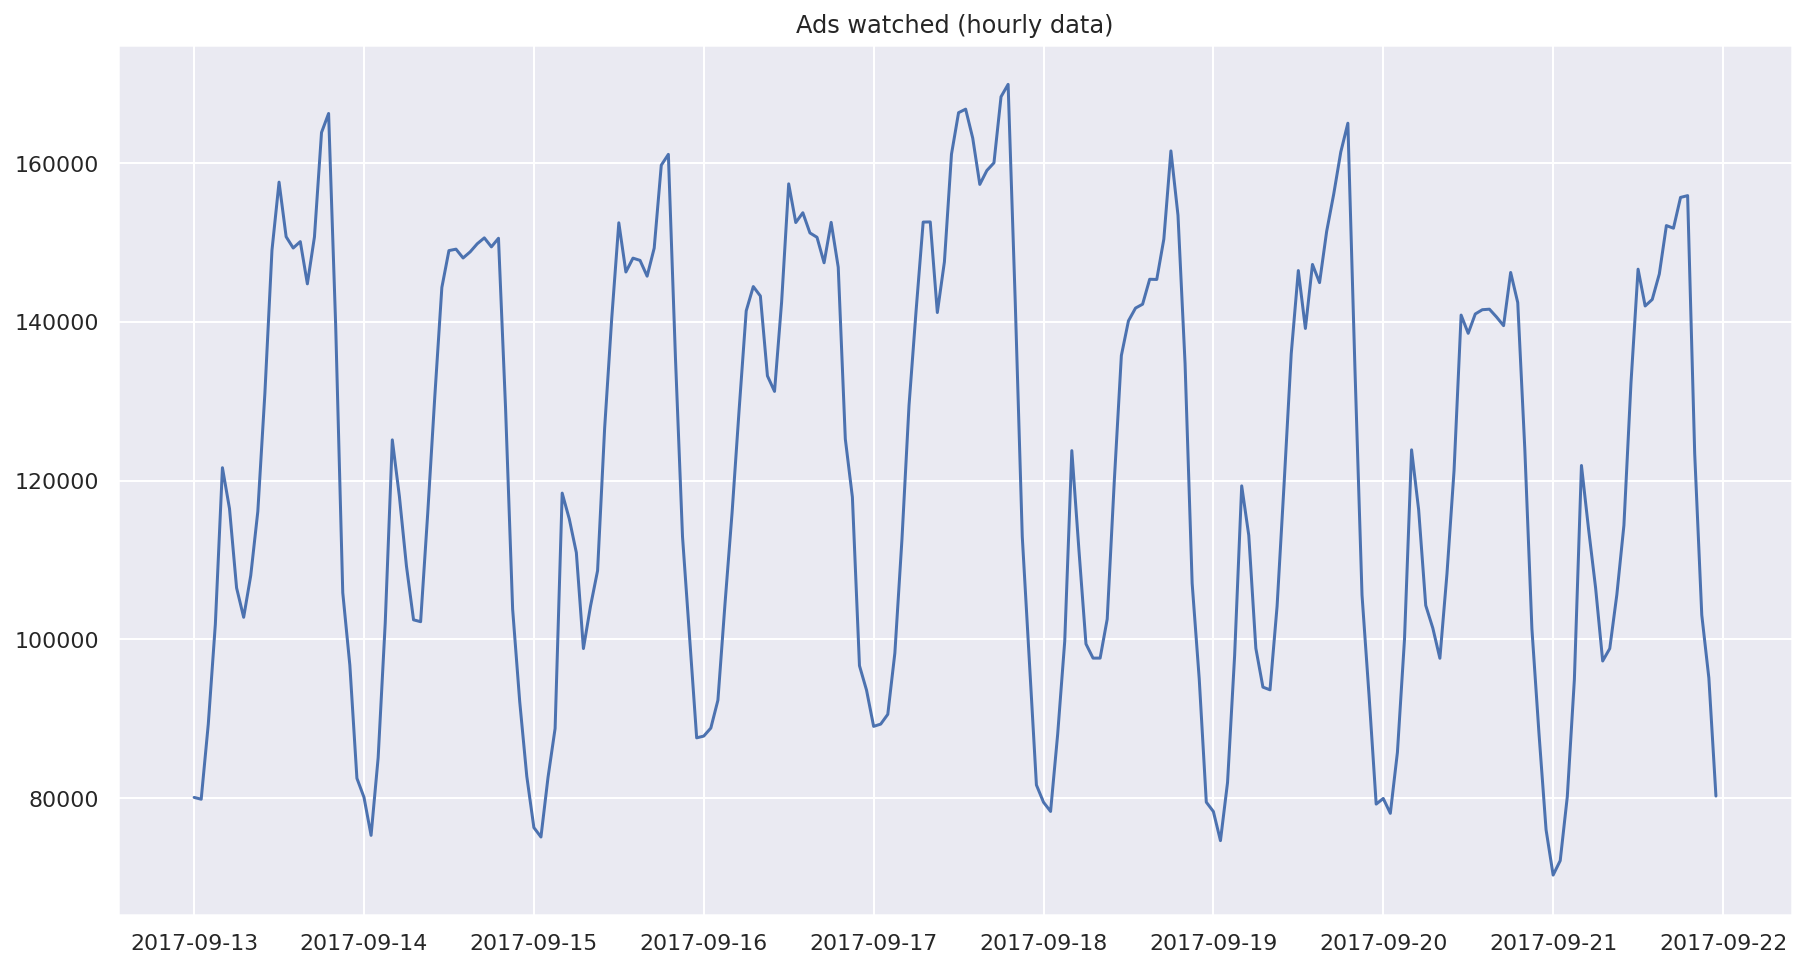

In [14]:
plt.figure(figsize=(15, 8))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

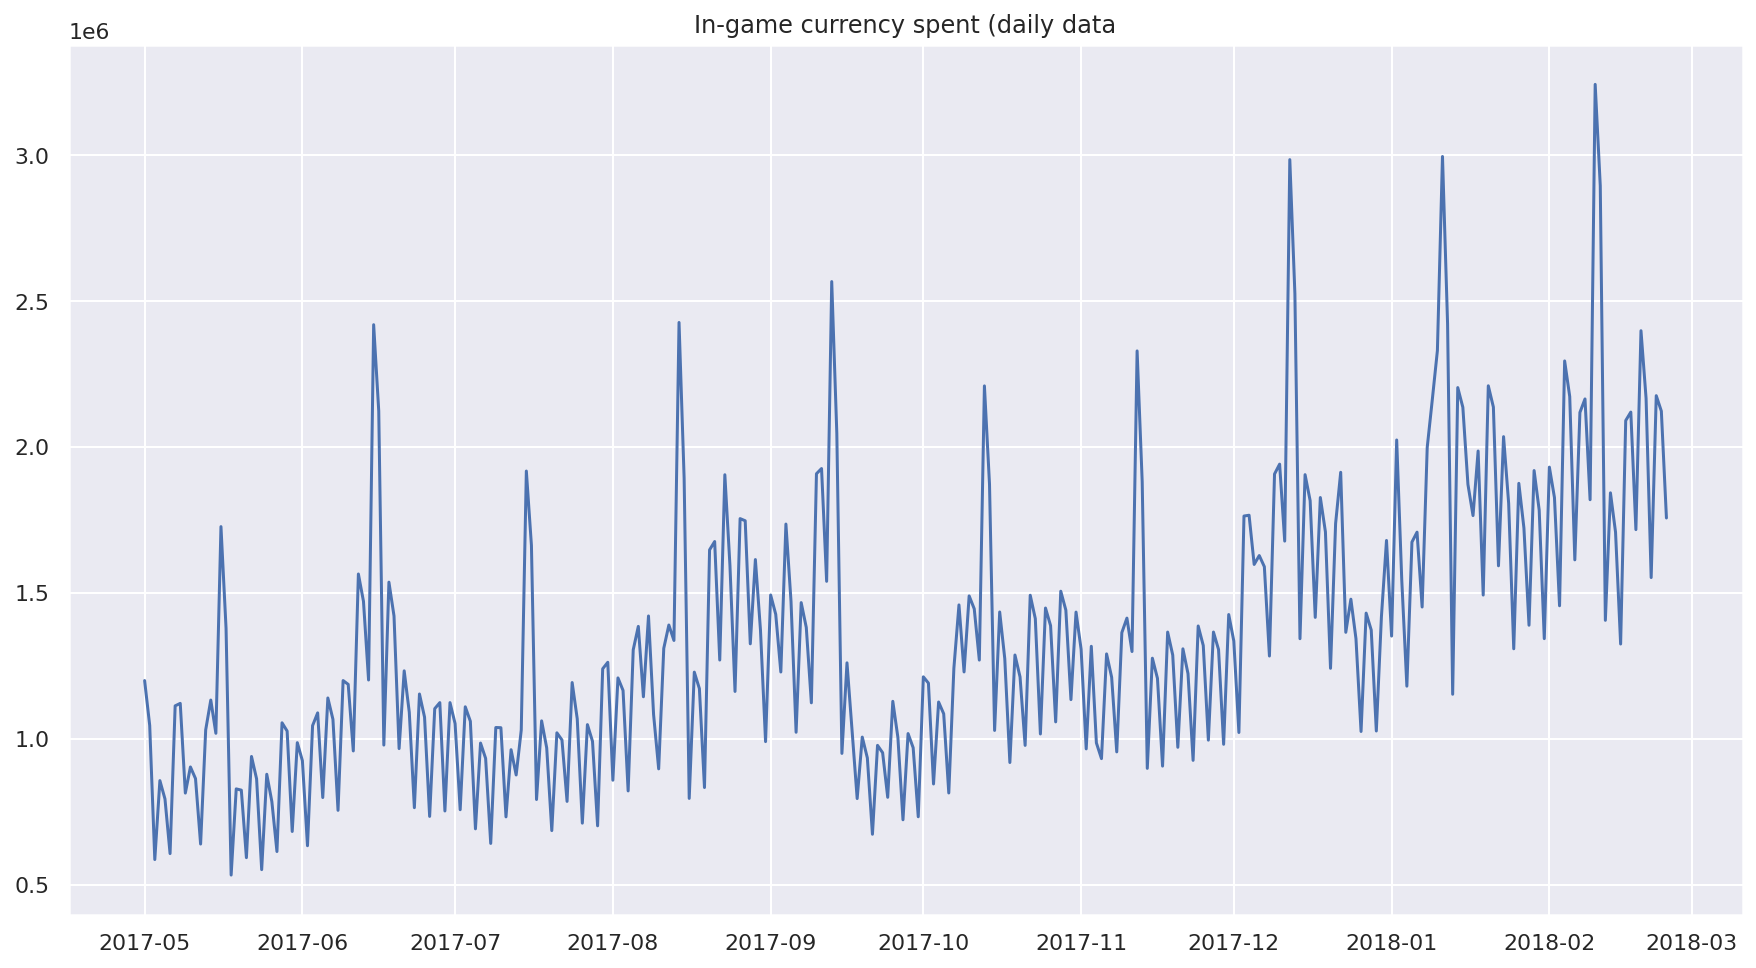

In [15]:
plt.figure(figsize=(15,8))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('In-game currency spent (daily data')
plt.grid(True)
plt.show()

## Forecast quality metrics

Before we begin forecasting, let's understand how to measure the quality of our predictions and take a look at the most commonly used metrics.

- [R squared](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination): coefficient of determination (in econometrics, this can be interpreted as the percentage of variance explained by the model), $(-\infty, 1]$

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$ 

```python
sklearn.metrics.r2_score
```
---
- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error): this is an interpretable metric because it has the same unit of measurment as the initial series, $[0, +\infty)$

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$ 

```python
sklearn.metrics.mean_absolute_error
```
---
- [Median Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error): again, an interpretable metric that is particularly interesting because it is robust to outliers, $[0, +\infty)$

$MedAE = median(|y_1 - \hat{y}_1|, ... , |y_n - \hat{y}_n|)$

```python
sklearn.metrics.median_absolute_error
```
---
- [Mean Squared Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error): the most commonly used metric that gives a higher penalty to large errors and vice versa, $[0, +\infty)$

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

```python
sklearn.metrics.mean_squared_error
```
---
- [Mean Squared Logarithmic Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error): practically, this is the same as MSE, but we take the logarithm of the series. As a result, we give more weight to small mistakes as well. This is usually used when the data has exponential trends, $[0, +\infty)$

$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$

```python
sklearn.metrics.mean_squared_log_error
```
---
- Mean Absolute Percentage Error: this is the same as MAE but is computed as a percentage, which is very convenient when you want to explain the quality of the model to management, $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

```python
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
```

In [16]:
# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Move, smoothe, evaluate

Let's start with a naive hypothesis: "tomorrow will be the same as today". However, instead of a model like $\hat{y}_{t} = y_{t-1}$ (which is actually a great baseline for any time series prediction problems and sometimes is impossible to beat), we will assume that the future value of our variable depends on the average of its $k$ previous values. Therefore, we will use the **moving average**.

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{t-n}$

In [17]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(ads, 24) # prediction for the last observed day (past 24 hours)

116805.0

Unfortunately, we cannot make predictions far in the future - in order to get the value for the next step, we need the previous values to be actually observed. But moving average has another use case - smoothing the original time series to identify trends. Pandas has an implementation available with [`DataFrame.rolling(window).mean()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html). The wider the window, the smoother the trend. In the case of very noisy data, which is often encountered in finance, this procedure can help detect common patterns.

In [26]:
def plotMovingAverage(series,window,plot_intervals=False,scale=1.96,plot_anomalies=False):
  """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies
  """
  rolling_mean = series.rolling(window=window).mean()
  
  print(rolling_mean[:window])

  plt.figure(figsize=(15,5))
  plt.title("Moving average\n window size = {}".format(window))
  plt.plot(rolling_mean, "g", label="Rolling mean trend")

  # Plot confidence intervals for smoothed values
  if plot_intervals:
    mae = mean_absolute_error(series[window:],rolling_mean[window:])
    deviation = np.std(series[window:] - rolling_mean[window:])
    lower_bound = rolling_mean - (mae+scale*deviation)
    upper_bound = rolling_mean + (mae+scale*deviation)
    plt.plot(upper_bound, "r--", label="Upper Bond / Lower Bond")
    plt.plot(lower_bound, "r--")

  # Having the intervals, find abnormal values
  if plot_anomalies:
    anomalies = pd.DataFrame(index = series.index, columns= series.columns)
    anomalies[series<lower_bound] = series[series<lower_bound]
    anomalies[series>upper_bound] = series[series>upper_bound]
    plt.plot(anomalies, "ro", markersize=10) 

  plt.plot(series[window:], label="Actual values")
  plt.legend(loc="upper left")
  plt.grid(True)

                          Ads
Time                         
2017-09-13 00:00:00       NaN
2017-09-13 01:00:00       NaN
2017-09-13 02:00:00       NaN
2017-09-13 03:00:00  87813.75
                               Ads
Time                              
2017-09-13 00:00:00            NaN
2017-09-13 01:00:00            NaN
2017-09-13 02:00:00            NaN
2017-09-13 03:00:00            NaN
2017-09-13 04:00:00            NaN
2017-09-13 05:00:00            NaN
2017-09-13 06:00:00            NaN
2017-09-13 07:00:00            NaN
2017-09-13 08:00:00            NaN
2017-09-13 09:00:00            NaN
2017-09-13 10:00:00            NaN
2017-09-13 11:00:00  108573.333333
                               Ads
Time                              
2017-09-13 00:00:00            NaN
2017-09-13 01:00:00            NaN
2017-09-13 02:00:00            NaN
2017-09-13 03:00:00            NaN
2017-09-13 04:00:00            NaN
2017-09-13 05:00:00            NaN
2017-09-13 06:00:00            NaN
2017-09-13 07:0

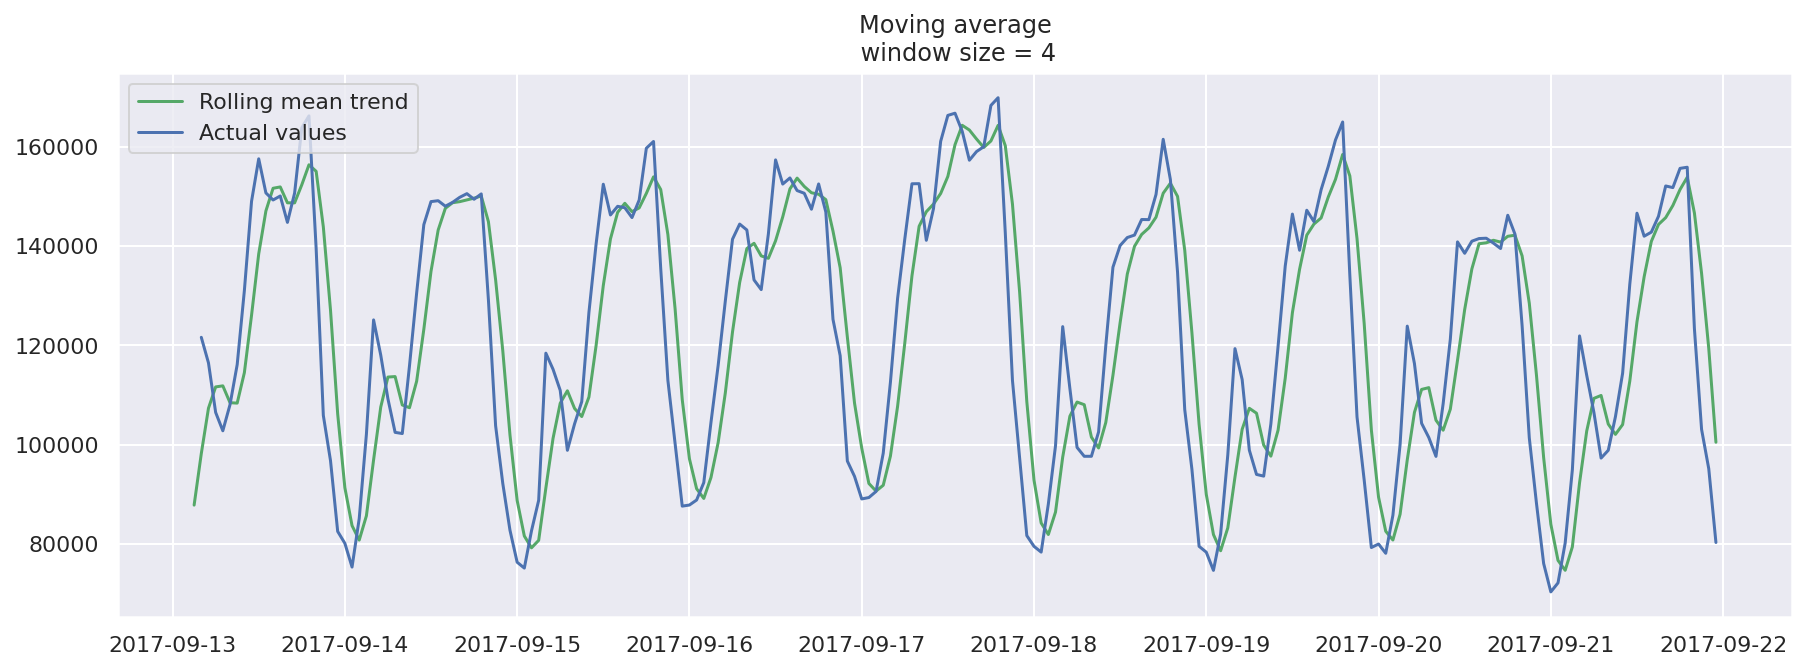

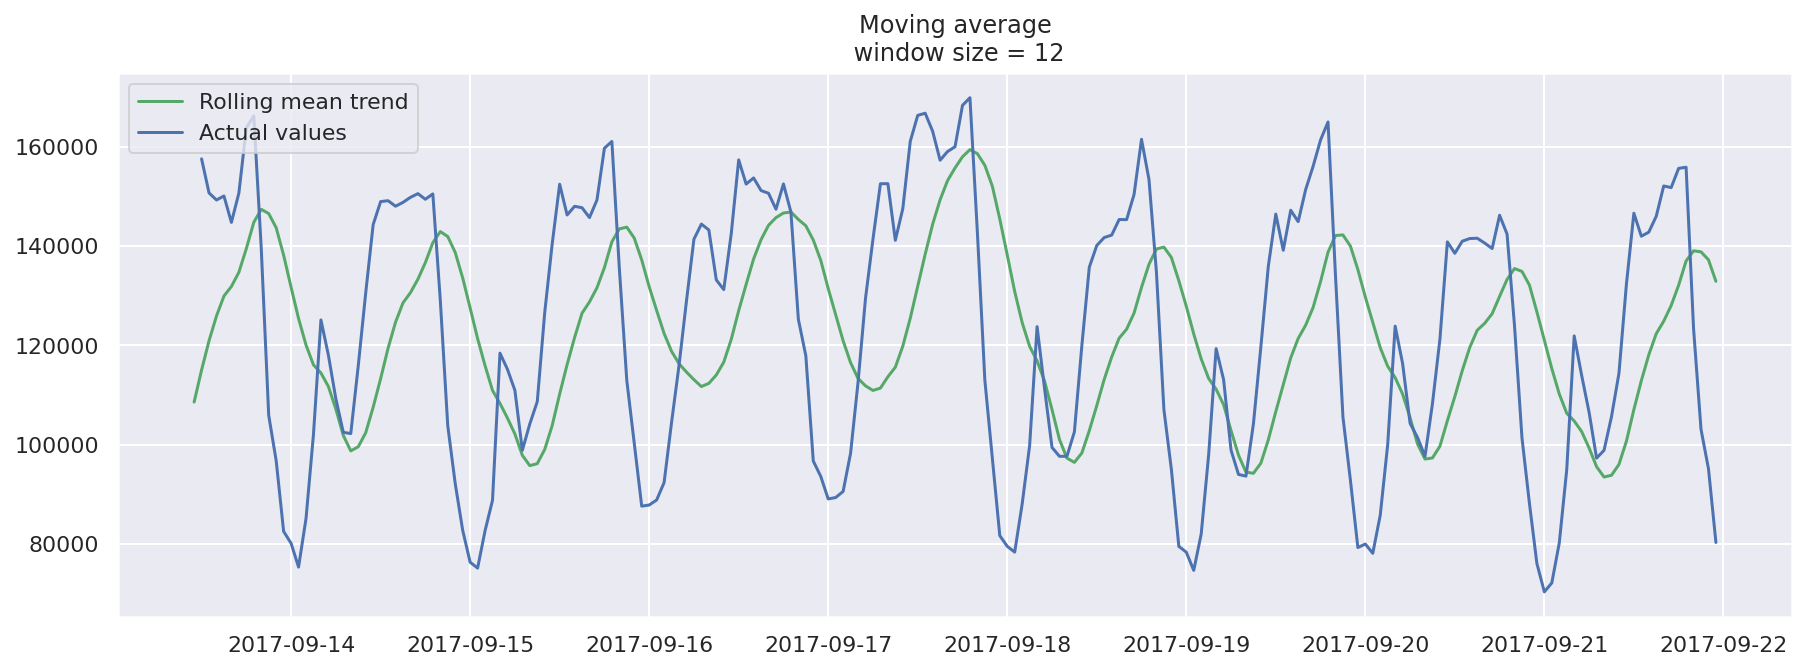

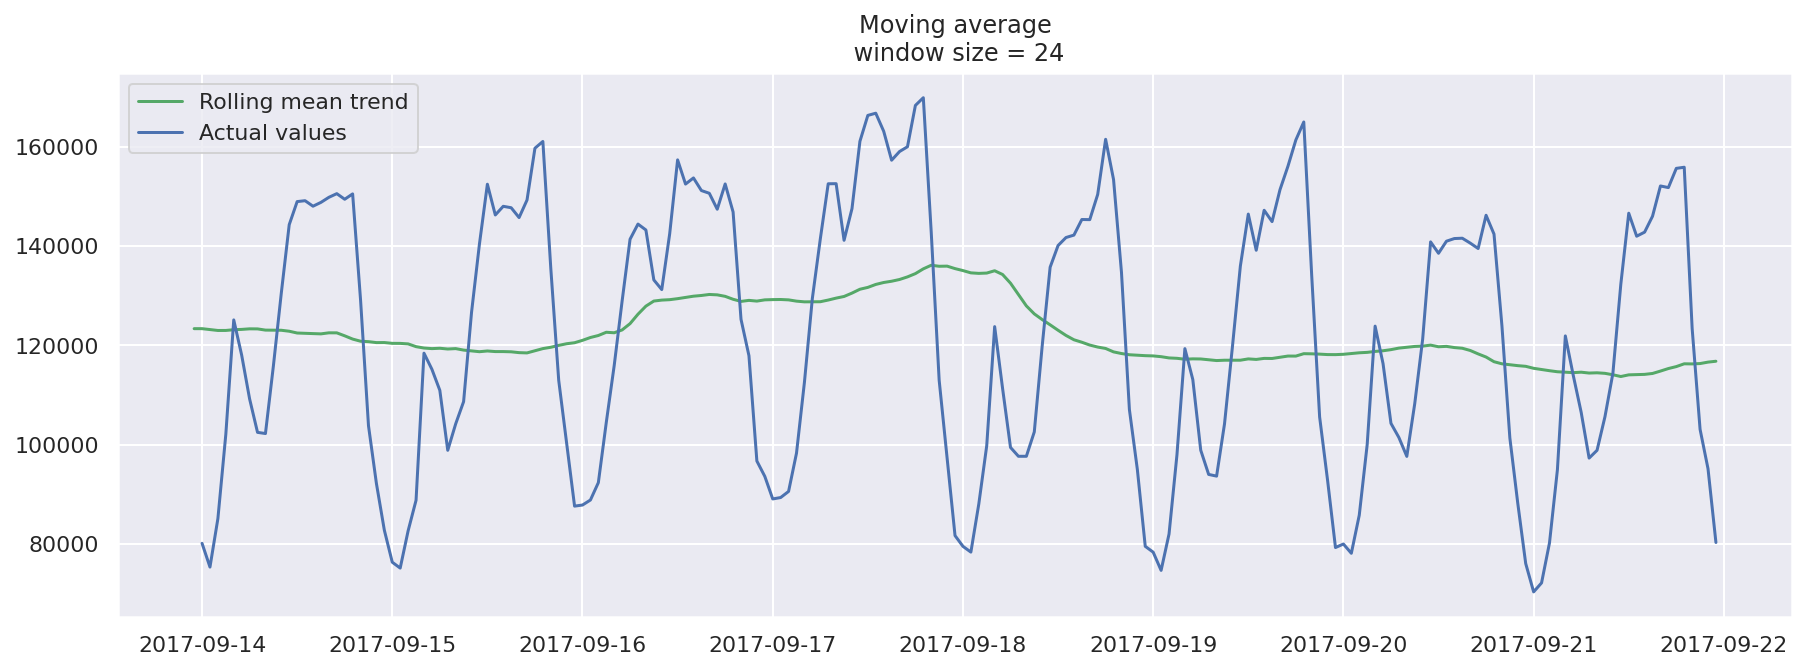

In [19]:
"Let's smooth by the previous 4,12,24 hours."
plotMovingAverage(ads,4)
plotMovingAverage(ads,12)
plotMovingAverage(ads,24)

                          Ads
Time                         
2017-09-13 00:00:00       NaN
2017-09-13 01:00:00       NaN
2017-09-13 02:00:00       NaN
2017-09-13 03:00:00  87813.75
                          Ads
Time                         
2017-09-13 00:00:00       NaN
2017-09-13 01:00:00       NaN
2017-09-13 02:00:00       NaN
2017-09-13 03:00:00  87813.75


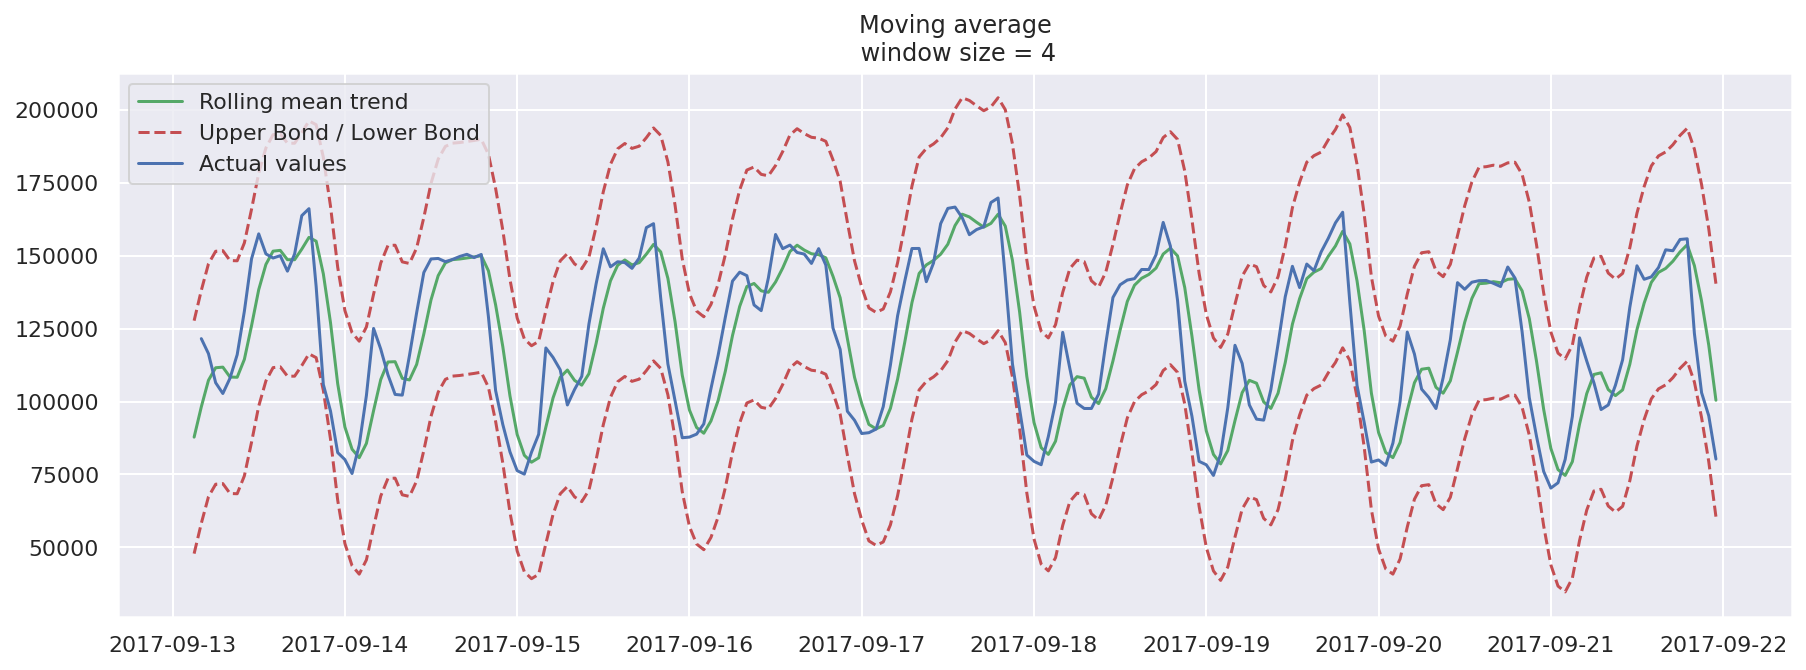

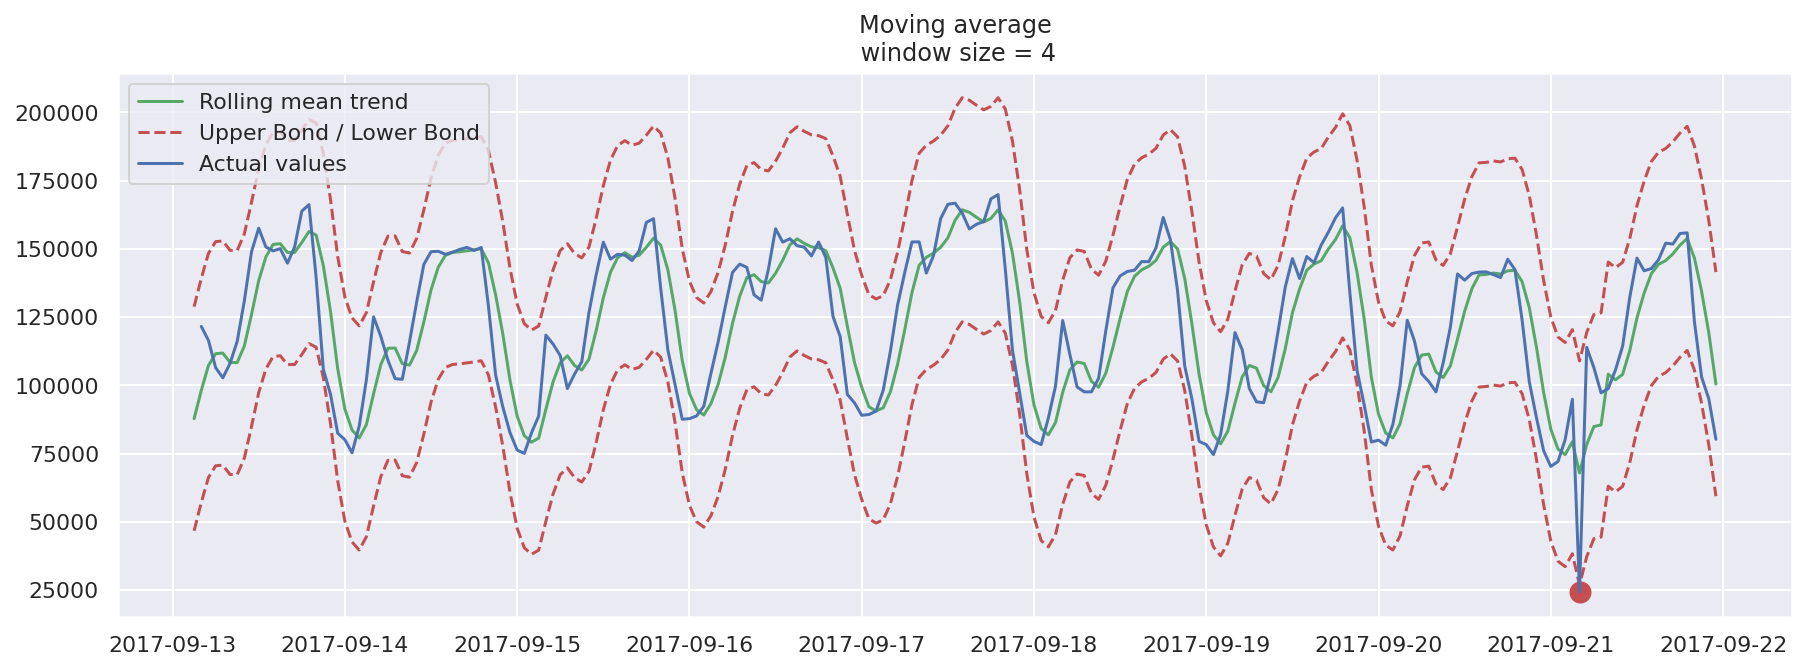

In [27]:
plotMovingAverage(ads, 4, plot_intervals=True)
"as the data set don't contain any anomilies add myself"
ads_anomaly = ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2 # say we have 80% drop of ads 
plotMovingAverage(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)

            GEMS_GEMS_SPENT
Time                       
2017-05-01              NaN
2017-05-02              NaN
2017-05-03              NaN
2017-05-04              NaN
2017-05-05              NaN
2017-05-06              NaN
2017-05-07    885819.428571


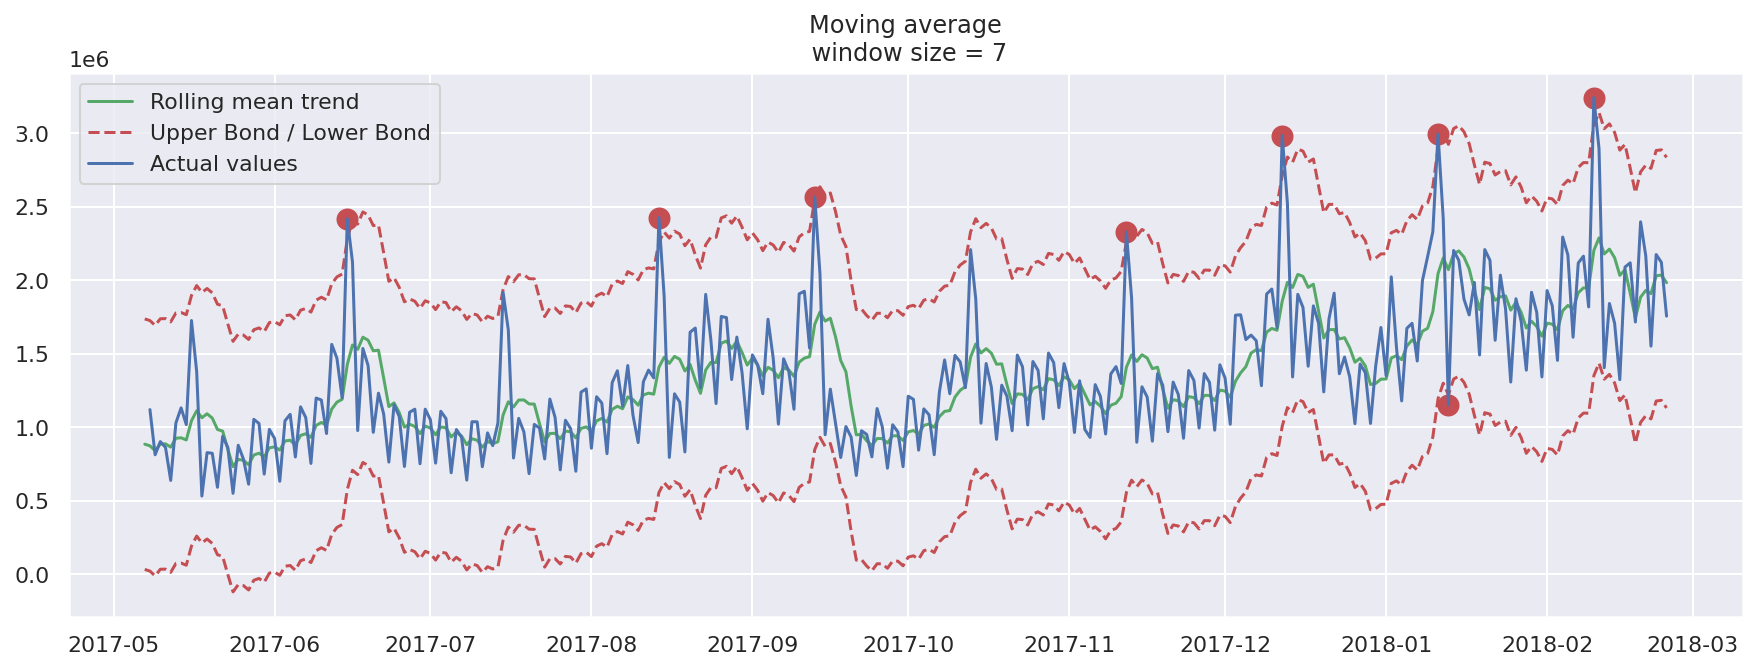

In [28]:
"for second series"
plotMovingAverage(currency, 7, plot_intervals=True, plot_anomalies=True) # weekly smoothing

**Weighted average** is a simple modification to the moving average. The weights sum up to `1` with larger weights assigned to more recent observations.


$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$

In [34]:
def weighted_average(series, weights):
    """
      Calculate weighted average on series
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
      result += series.iloc[-n-1]*weights[n]
    return float(result)

In [35]:
weighted_average(ads, [0.6, 0.3, 0.1])

98423.0

## Exponential smoothing

Now, let's see what happens if, instead of weighting the last $k$ values of the time series, we start weighting all available observations while exponentially decreasing the weights as we move further back in time. There exists a formula for **[exponential smoothing](https://en.wikipedia.org/wiki/Exponential_smoothing)** that will help us with this:

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

Here the model value is a weighted average between the current true value and the previous model values. The $\alpha$ weight is called a smoothing factor. It defines how quickly we will "forget" the last available true observation. The smaller $\alpha$ is, the more influence the previous observations have and the smoother the series is.

Exponentiality is hidden in the recursiveness of the function – we multiply by $(1-\alpha)$ each time, which already contains a multiplication by $(1-\alpha)$ of previous model values.

In [36]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [43]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):
      plt.figure(figsize=(15,8))
      for alpha in alphas:
        plt.plot(exponential_smoothing(series,alpha),label = "Alpha {}".format(alpha))
      plt.plot(series.values,"c",label="Actual")
      plt.legend(loc="best")
      plt.axis('tight')
      plt.title("Exponential Smoothing")
      plt.grid(True)

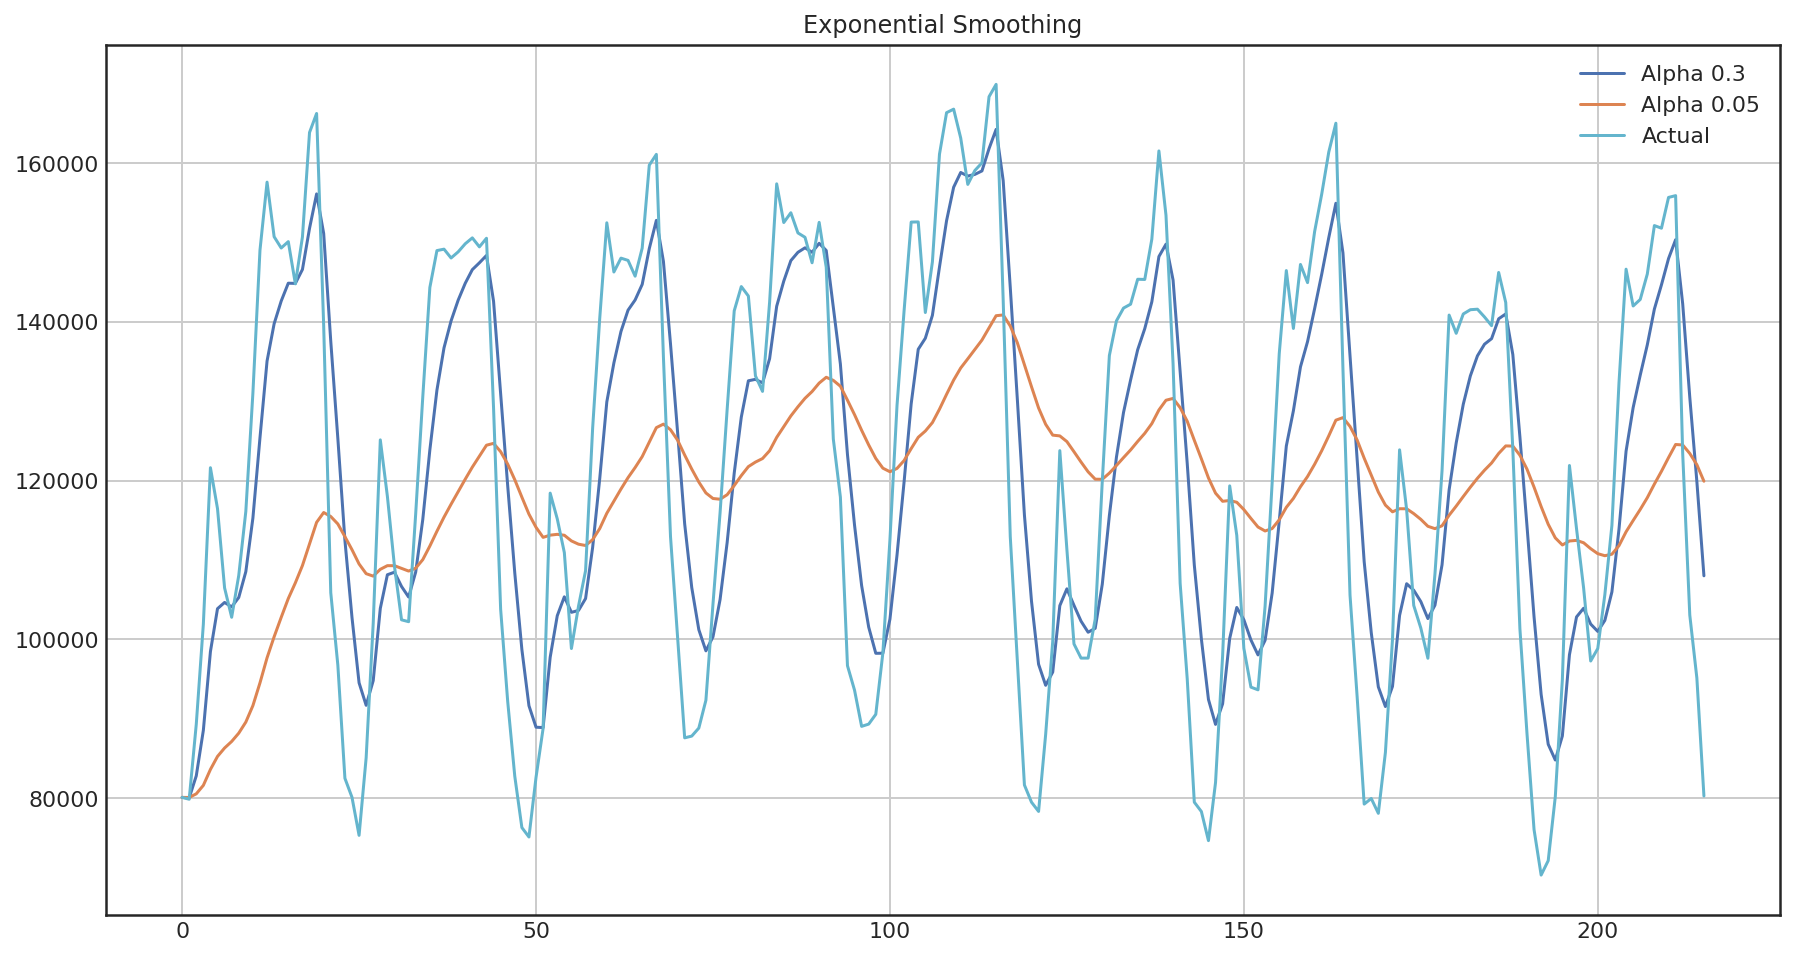

In [44]:
plotExponentialSmoothing(ads.Ads, [0.3, 0.05])

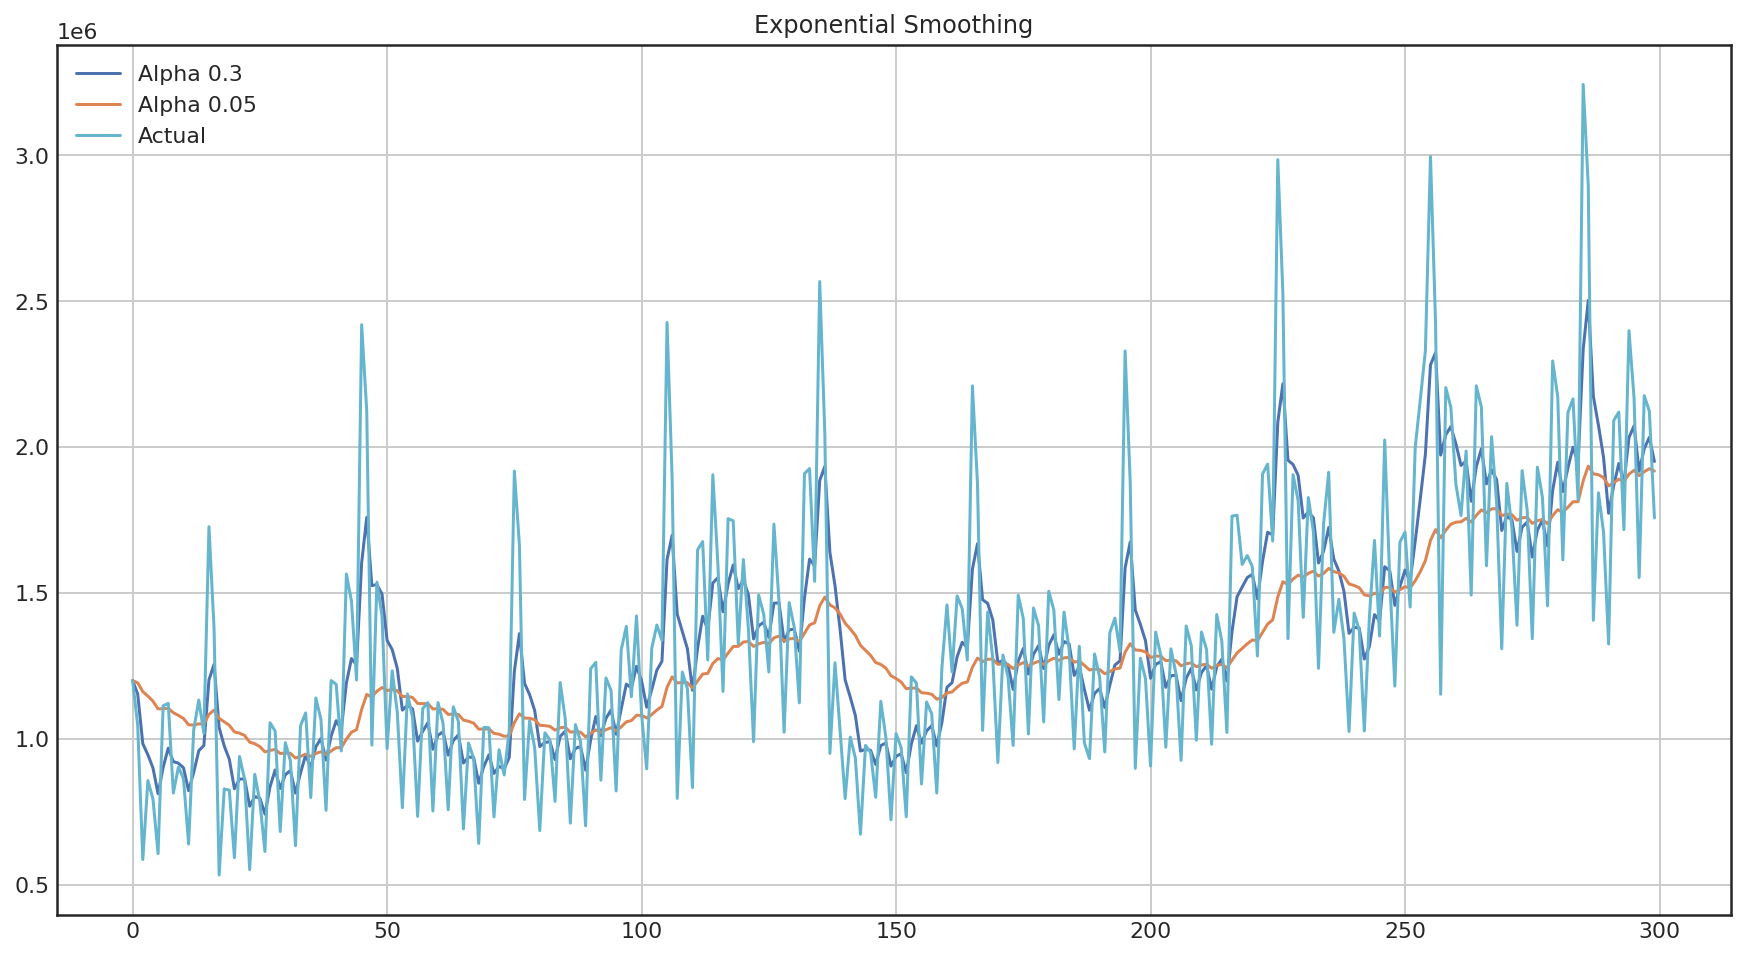

In [45]:
plotExponentialSmoothing(currency.GEMS_GEMS_SPENT, [0.3, 0.05])